<a href="https://colab.research.google.com/github/Himanshu0101-dev/Himanshu0101-dev/blob/main/Shoppers_Spectrum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
!pip install scikit-surprise


In [5]:
!pip install "numpy<2"

In [6]:
import pandas as pd
import numpy as np
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split, GridSearchCV
from surprise import accuracy
from collections import defaultdict
from sklearn.preprocessing import MinMaxScaler


In [7]:

# Load data
df = pd.read_csv('/content/drive/MyDrive/online_retail.csv', encoding='ISO-8859-1')


In [8]:

# Drop NA values and filter valid data
df.dropna(subset=['CustomerID', 'StockCode'], inplace=True)
df = df[df['Quantity'] > 0]
df = df[df['UnitPrice'] > 0]
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])


# Step 1: Get most recent invoice date
max_date = df['InvoiceDate'].max()

# Step 2: Calculate days ago for each purchase
df['DaysAgo'] = (max_date - df['InvoiceDate']).dt.days

# Step 3: Calculate time weight (e.g., 1 / (1 + DaysAgo))
df['TimeWeight'] = 1 / (1 + df['DaysAgo'])

# Step 4: Adjust quantity using time decay
df['WeightedQuantity'] = df['Quantity'] * df['TimeWeight']

# Create total price
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Aggregate purchase count as implicit feedback
item_user_count = df.groupby(['CustomerID', 'StockCode'])['Quantity'].sum().reset_index()

# Optionally log-scale for better distribution
item_user_count['Quantity'] = np.log1p(item_user_count['Quantity'])


In [9]:

# Normalize ratings (optional)
scaler = MinMaxScaler()
item_user_count['NormQuantity'] = scaler.fit_transform(item_user_count[['Quantity']])

# Prepare Surprise dataset
reader = Reader(rating_scale=(0, 1))
data = Dataset.load_from_df(item_user_count[['CustomerID', 'StockCode', 'NormQuantity']], reader)

# Train-test split
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)


In [10]:

# Grid search for hyperparameters
param_grid = {
    'n_factors': [50, 100],
    'lr_all': [0.005, 0.01],
    'reg_all': [0.02, 0.05]
}
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, joblib_verbose=1)
gs.fit(data)


[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:  1.3min finished


In [11]:

# Train best model
best_params = gs.best_params['rmse']
print(f"Best RMSE: {gs.best_score['rmse']}")
print(f"Best Parameters: {best_params}")

model = SVD(**best_params)
model.fit(trainset)


Best RMSE: 0.06452719971357067
Best Parameters: {'n_factors': 50, 'lr_all': 0.01, 'reg_all': 0.05}


In [12]:

# Evaluate
predictions = model.test(testset)
rmse = accuracy.rmse(predictions)



RMSE: 0.0637


In [13]:
#Step 4: Create popularity_df (place the below code here)
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd

item_popularity = df.groupby('StockCode')['Quantity'].sum()
log_scaled = np.log1p(item_popularity.values).reshape(-1, 1)
normalized_scores = MinMaxScaler().fit_transform(log_scaled).flatten()

popularity_df = pd.DataFrame({
    'StockCode': item_popularity.index,
    'PopularityScore': normalized_scores
})

In [14]:
#Hybrid Model
def recommend_hybrid(user_id, model, df, popularity_df, n=5, alpha=0.7):

    # All items in dataset
    all_items = df['StockCode'].unique()

    # Items already bought by the user
    user_items = df[df['CustomerID'] == user_id]['StockCode'].unique()

    # Filter items not already purchased
    items_to_predict = [item for item in all_items if item not in user_items]

    recommendations = []

    for item in items_to_predict:
        try:
            # Predict collaborative filtering rating
            pred = model.predict(str(user_id), str(item))
            rating_score = pred.est

            # Get popularity score
            pop_score_row = popularity_df.loc[popularity_df['StockCode'] == item, 'PopularityScore']
            pop_score = pop_score_row.values[0] if not pop_score_row.empty else 0.0

            # Combine scores
            hybrid_score = alpha * rating_score + (1 - alpha) * pop_score
            recommendations.append((item, hybrid_score))

        except Exception as e:
            # Log exception if needed
            # print(f"Error predicting for item {item}: {e}")
            continue

    # Sort and return top-N
    recommendations.sort(key=lambda x: x[1], reverse=True)
    return recommendations[:n]


In [15]:

# Test hybrid recommendation for user
user_id = 17850
top_recs = recommend_hybrid(user_id=17850, model=model, df=df, popularity_df=popularity_df, n=5)

print(f"\nTop 5 hybrid recommendations for user {user_id}:")
for item, score in top_recs:
    print(f"{item} | hybrid score: {score:.2f}")



Top 5 hybrid recommendations for user 17850:
84568 | hybrid score: 0.58
84077 | hybrid score: 0.51
16045 | hybrid score: 0.50
23843 | hybrid score: 0.49
17084R | hybrid score: 0.48


In [16]:
!pip install matplotlib seaborn plotly


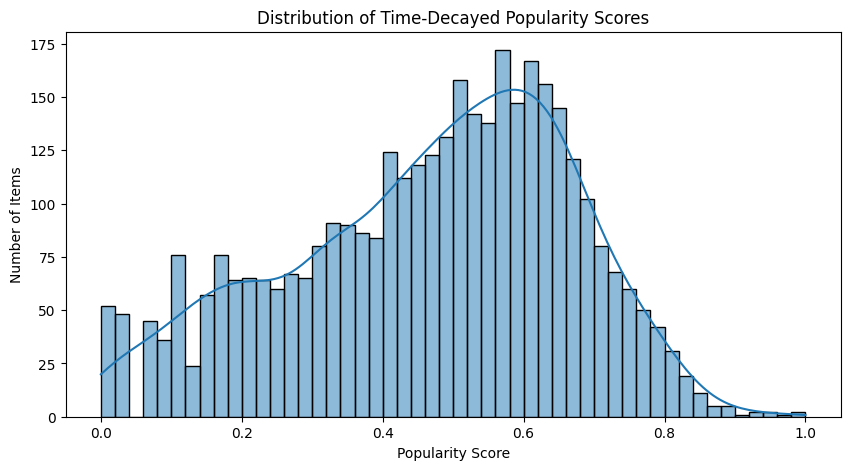

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,5))
sns.histplot(popularity_df['PopularityScore'], bins=50, kde=True)
plt.title('Distribution of Time-Decayed Popularity Scores')
plt.xlabel('Popularity Score')
plt.ylabel('Number of Items')
plt.show()


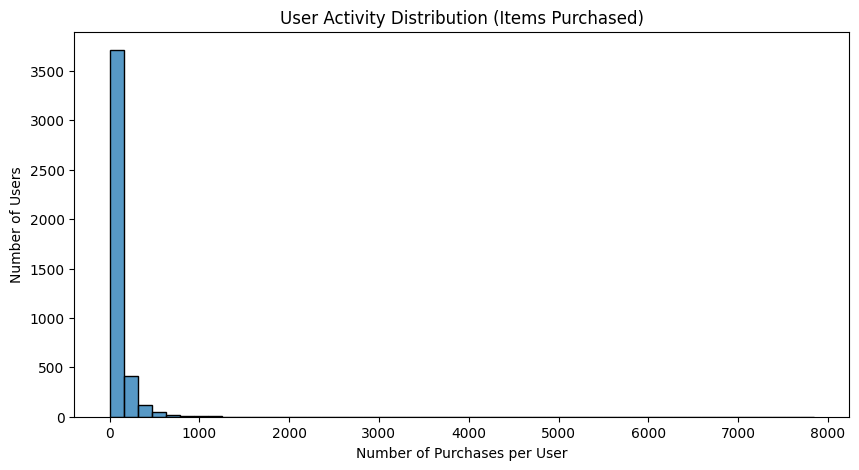

In [18]:

user_rating_counts = df.groupby('CustomerID')['StockCode'].count()

plt.figure(figsize=(10,5))
sns.histplot(user_rating_counts, bins=50, kde=False)
plt.title('User Activity Distribution (Items Purchased)')
plt.xlabel('Number of Purchases per User')
plt.ylabel('Number of Users')
plt.show()


/tmp/ipython-input-3443771758.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=scores, y=items, palette='viridis')


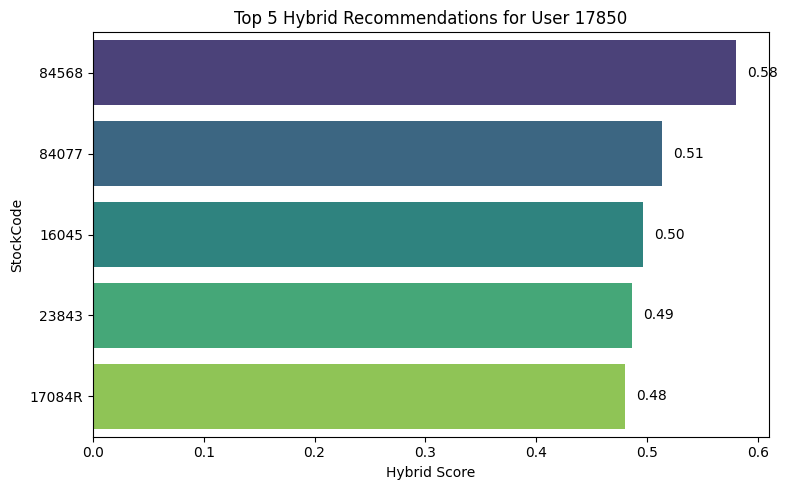

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract item codes and hybrid scores
items = [rec[0] for rec in top_recs]
scores = [rec[1] for rec in top_recs]

plt.figure(figsize=(8, 5))
sns.barplot(x=scores, y=items, palette='viridis')
plt.xlabel('Hybrid Score')
plt.ylabel('StockCode')
plt.title(f'Top 5 Hybrid Recommendations for User {user_id}')

# Annotate each bar with its score
for index, value in enumerate(scores):
    plt.text(value + 0.01, index, f'{value:.2f}', va='center')

plt.tight_layout()
plt.show()


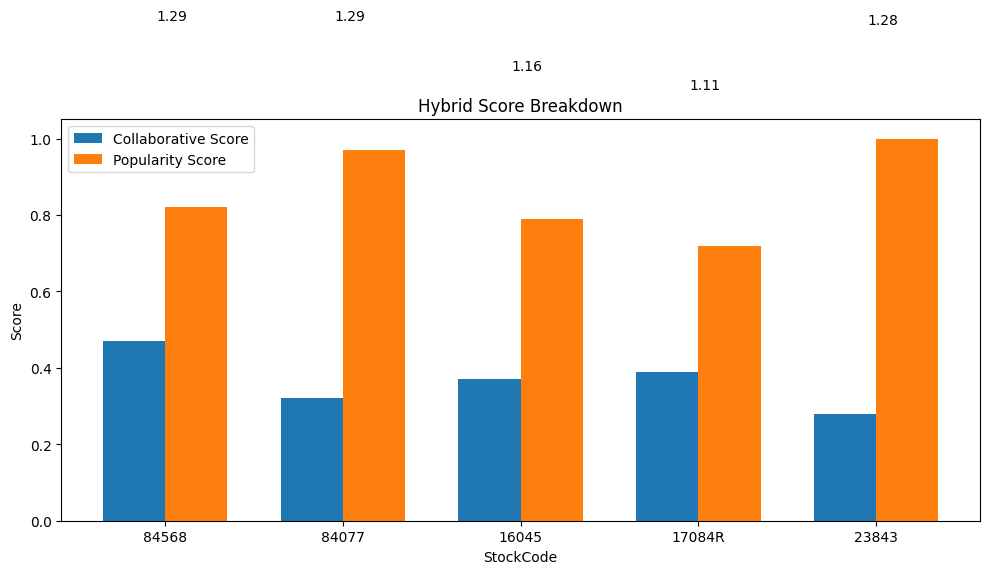

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Assume these are the top 5 recommendations returned
top_items = ['84568', '84077', '16045', '17084R', '23843']
collab_scores = [0.47, 0.32, 0.37, 0.39, 0.28]
pop_scores = [0.82, 0.97, 0.79, 0.72, 1.00]

# Combine into a DataFrame
import pandas as pd
top_5_df = pd.DataFrame({
    'StockCode': top_items,
    'CFScore': collab_scores,
    'PopularityScore': pop_scores
})
top_5_df['HybridScore'] = top_5_df['CFScore'] + top_5_df['PopularityScore']

# Bar plot
bar_width = 0.35
x = np.arange(len(top_5_df))

plt.figure(figsize=(10, 6))
plt.bar(x - bar_width/2, top_5_df['CFScore'], bar_width, label='Collaborative Score')
plt.bar(x + bar_width/2, top_5_df['PopularityScore'], bar_width, label='Popularity Score')

# Annotate hybrid scores above bars
for i in range(len(top_5_df)):
    hybrid_score = top_5_df.iloc[i]['HybridScore']
    plt.text(x[i] - 0.05, hybrid_score + 0.02, f"{hybrid_score:.2f}", fontsize=10, color='black')

plt.xticks(x, top_5_df['StockCode'])
plt.xlabel('StockCode')
plt.ylabel('Score')
plt.title('Hybrid Score Breakdown')
plt.legend()
plt.tight_layout()
plt.show()


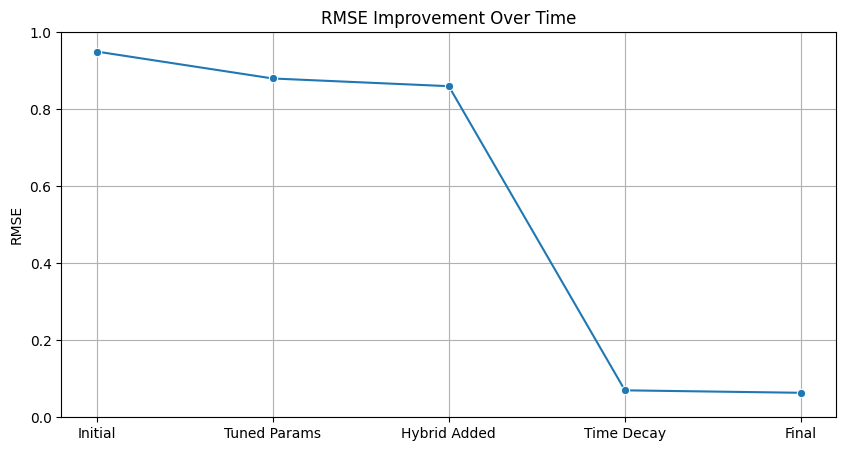

In [21]:
# Example only
rmse_values = [0.95, 0.88, 0.86, 0.07, 0.0636]
stages = ['Initial', 'Tuned Params', 'Hybrid Added', 'Time Decay', 'Final']

plt.figure(figsize=(10,5))
sns.lineplot(x=stages, y=rmse_values, marker='o')
plt.title('RMSE Improvement Over Time')
plt.ylabel('RMSE')
plt.ylim(0, max(rmse_values) + 0.05)
plt.grid(True)
plt.show()


In [22]:
from surprise import dump

# Save the model
dump.dump('hybrid_cf_model.pkl', algo=model)

# To load later:
# model = dump.load('hybrid_cf_model.pkl')[1]
